# Import Libraries

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import datetime
from time import time


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Prediction libraries
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import xgboost as xgb
from lightgbm import LGBMRegressor

In [2]:
test = pd.read_csv(r'C:\Users\irind\Desktop\MMA_Courses\INSY 695_Enterprise\walmart-recruiting-store-sales-forecasting\Final\test.csv')
train = pd.read_csv(r'C:\Users\irind\Desktop\MMA_Courses\INSY 695_Enterprise\walmart-recruiting-store-sales-forecasting\Final\train.csv')
features = pd.read_csv(r'C:\Users\irind\Desktop\MMA_Courses\INSY 695_Enterprise\walmart-recruiting-store-sales-forecasting\Final\features.csv')
sample = pd.read_csv(r'C:\Users\irind\Desktop\MMA_Courses\INSY 695_Enterprise\walmart-recruiting-store-sales-forecasting\Final\sampleSubmission.csv')
stores = pd.read_csv(r'C:\Users\irind\Desktop\MMA_Courses\INSY 695_Enterprise\walmart-recruiting-store-sales-forecasting\Final\stores.csv')


# Data Exploration

## Stores DF

In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
stores.info()
#There are 45 stores in total in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [7]:
stores.describe()
#Average store size is 130,287 SQFT
#Most stores are around 202,307 SQFT

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


### Look for NULL values in stores DF

In [8]:
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


There are NULL rows in Stores DF

In [11]:
# Groupby store size to see how large each store type is on average
stores['Size'].groupby(stores['Type']).mean()

Type
A    190992.5
B    109865.0
C     39511.7
Name: Size, dtype: float64

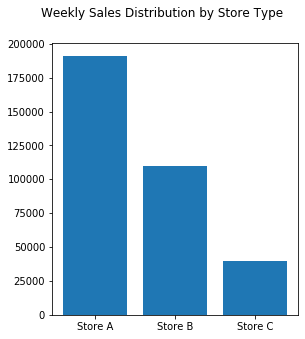

In [23]:
names = ['Store A', 'Store B', 'Store C']
values = [190992.4, 109865.0, 39511.7]

plt.figure(figsize=(15, 5))

plt.subplot(132)
plt.bar(names, values)
plt.suptitle('Weekly Sales Distribution by Store Type')
plt.show()

Store type 'A' are the largest types, while 'C' are the smallest Wallmart stores

### Visualization of distribution of stores

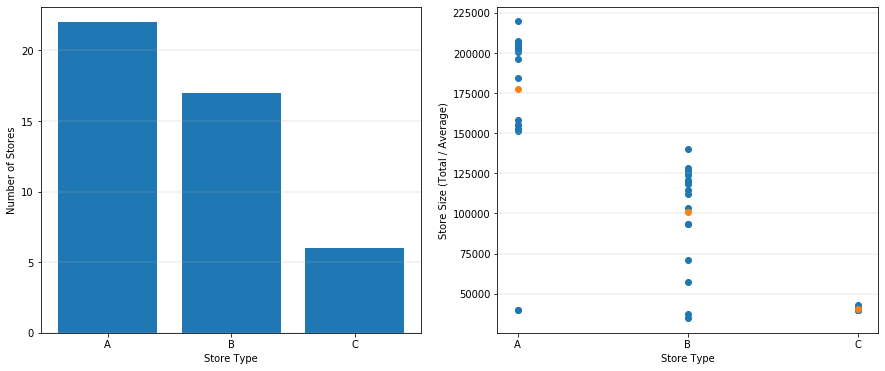

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).count())
ax[0].set_ylabel('Number of Stores')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].scatter(stores['Type'], stores['Size'])
ax[1].scatter(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).mean()) #Store Type Average Store Size Vs 
ax[1].set_ylabel('Store Size (Total / Average)')
ax[1].set_xlabel('Store Type')
ax[1].yaxis.grid(True, linewidth=0.3)

Most stores in the dataset are part of store type 'A' and distribution of store sizes

#### Identify outliers in Stores df

In [11]:
stores[(stores['Size'] < 40000) & (~stores['Type'].isin(['C']))]

,Store,Type,Size
2,3,B,37392
4,5,B,34875
32,33,A,39690
35,36,A,39910


The following are outliers which show unusually small sized stores in correspondence with the other stores of the same type.


### Takeaways:

   1. Column TYPE is a candidate for dummifying.
   2. Most stores are of TYPE='A'. Only a few stores are of TYPE='C'.
   3. TYPE columns seem to be linked to Store Size. Average store size of TYPE 'A' is ~ 175k, TYPE 'B' is ~ 100k and TYPE 'C' is ~40k
   4. Four stores [3, 5, 33 & 36] whose size is < 40k, seem to have been incorrectly tagged as Types A & B. We should drop theses



## Features DF

In [12]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


In [14]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [15]:
#missing data

total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)



,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


<BarContainer object of 12 artists>

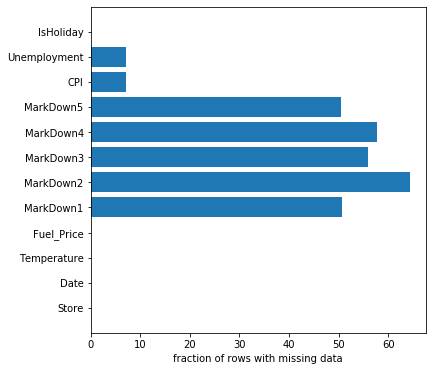

In [16]:
# Distribution of NaNs for all columns

features_missing = features.isna().sum()/len(features) * 100

#Visualize
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)



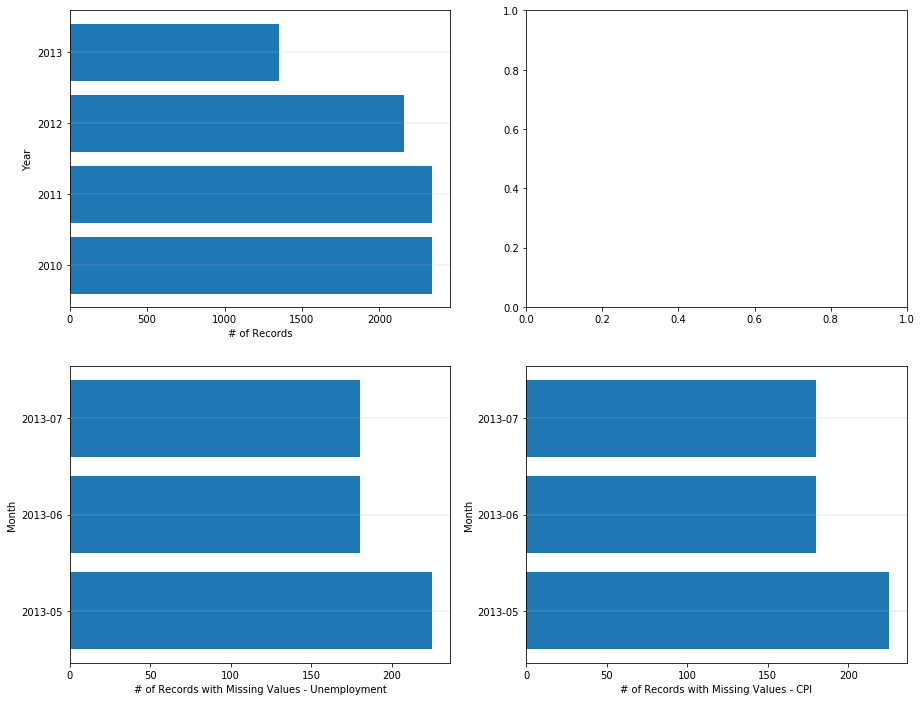

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (15,12))

# Plot 1: Year Vs # of Records
ax[0,0].barh(features['Date'].str.slice(start=0, stop=4).unique(), 
          features['Date'].str.slice(start=0, stop=4).value_counts())
ax[0,0].set_xlabel('# of Records')
ax[0,0].set_ylabel('Year')
ax[0,0].yaxis.grid(True, linewidth=0.3)

# Plot 2: Month Vs # of Records with Missing Values - Unemployment
ax[1,0].barh(features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts())
ax[1,0].set_xlabel('# of Records with Missing Values - Unemployment')
ax[1,0].set_ylabel('Month')
ax[1,0].yaxis.grid(True, linewidth=0.3)

# Plot 3: Month Vs # of Records with Missing Values - CPI
ax[1,1].barh(features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts())
ax[1,1].set_xlabel('# of Records with Missing Values - CPI')
ax[1,1].set_ylabel('Month')
ax[1,1].yaxis.grid(True, linewidth=0.3)

The number of records missing for various years. Followed by break down by month for Unemployment and CPI

In [18]:


holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas



In [19]:


# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()



True    585
Name: IsHoliday, dtype: int64

In [20]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

In [21]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
...                   ...           ...
2     2011-02  212.727665         8.028
      2011-03  213.877488         8.028
      2011-04  214.908582         7.931
      2011-05  215.398826         7.931
      2011-06  214.754360         7.931
      2011-07  214.998246         7.852
      2011-08  215.291750         7.852
      2011-09  215.810080         7.852
      2011-10  217.047711         7.441
      2011-11  217.777737         7.441
      2011-12  218.792544         7.441
      2012-01  219.558147         7.057
      2012-02  220.014484         7.057
      2012-03  220.791516         7.057
      2012-04  221.170021         6.891
      2012-05  221.358968         6.891
      2012-06  221.419302         6.891
      2012-07  221.557961         6.565
      2012-08  221.721490         6.565
      2012-09  222.331393         6.565
      2012-10  222.992375         6.170
      2012-11  223.159882         6.170
      2012-12  223.427985         6.170
      2013-01  223.821473         6.237
      2013-02  223.925989         6.237
      2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

In [22]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


Count of Markdown by Date

In [23]:
pip install setuptools

Note: you may need to restart the kernel to use updated packages.


In [24]:
import setuptools

In [25]:
#Explore Distribution
#distribution(features, ['Temperature','Fuel_Price'])



### Takeaways:

   1. Data requires pre-processing
   2. Column(s) ISHOLIDAY has been validated
   3. Column(s) UNEMPLOYMENT & CPI have missing values for May, Jun & Jul 2013. For these columns as the values dont change significantly month on month, value from Apr 2013 would be propogated over for each store.
   4. Column(s) MARKDOWN* have missing values for 2010 (entire year) and 2011 (until Nov). Additionally, there are missing values for other other dates as well.
   5. CPI and UNEMPLOYMENT value are a bit skewed. MARKDOWN* columns are skewed.



## Train DF

In [26]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [28]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [29]:
#Number of rows where Weekly Sales is 0

train['Store'][train['Weekly_Sales'] < 0].count()

1285

In [30]:
#Merge Train DF to Stores
train_outliers = pd.merge(train, stores, how='left', on=['Store'])

In [31]:
# Average Weekly Sales by Store Type
train_outliers.groupby(['Type'])['Weekly_Sales'].mean()

Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: Weekly_Sales, dtype: float64

In [32]:


# Average Weekly Sales for possibly misclassified Stores
train_outliers = train_outliers[train_outliers['Store'].isin([3,5,33,36])]
train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean()



Store  Type
3      B       6373.033983
5      B       5053.415813
33     A       5728.414053
36     A       8584.412563
Name: Weekly_Sales, dtype: float64

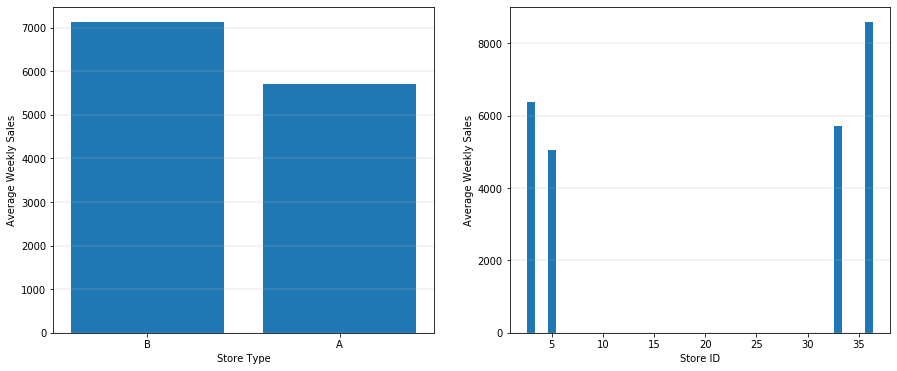

In [33]:
# Average Weekly Sales by Store Type
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(train_outliers['Type'].unique(), train_outliers.groupby(['Type'])['Weekly_Sales'].mean())
ax[0].set_ylabel('Average Weekly Sales')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].bar([3,5,33,36], train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean())
ax[1].set_ylabel('Average Weekly Sales')
ax[1].set_xlabel('Store ID')
ax[1].yaxis.grid(True, linewidth=0.3)

In [34]:
train_outliers = None


Takeaways:

   1. Column DATE is non-numeric and is a candidate for pre-processing.
   2. 1285 records with Weekly Sales < 0
   3. Data spans years 2010, 2011 and 2012
   4. As suspected above, four stores [3, 5, 33 & 36] seem to have incorrectly classified as Type A & B. Average Weekly Sales for these stores is in line with the average for Type C. Hence, these would need to be reclassified as Type C

## Test DF

In [35]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int64
Dept         115064 non-null int64
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [37]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [38]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64


Takeaways:

   1.  Column DATE is non-numeric and is a candidate for pre-processing.
   2.  Data spans years 2012 and 2013



# Data Pre-processing

## Correcting values

### Change store that were categorized incorrectly

In [3]:
stores[stores['Store'].isin([3,5,33,36])].index

Int64Index([2, 4, 32, 35], dtype='int64')

In [4]:
stores.iat[2, 1] = stores.iat[4, 1] = stores.iat[32, 1] = stores.iat[35, 1] = 'C'

The store numbers 3,5,33, and 36 are classified as 'C'

### Change negative values of Markdowns to 0

In [5]:
features['MarkDown1'] = features['MarkDown1'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown2'] = features['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown3'] = features['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown4'] = features['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown5'] = features['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

### Propagate for NaN rows of CPI and Unemployment

In [6]:
# Using 26/04/2013 values of CPI and Unemployment to impute into missing rows as this day is the 
#last day before we encounter NaN values

for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

### Impute Markdown for years 2010 - 2011

In [7]:
#Set weeks for each date to make it easier to categorize Markdown values

features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

In [8]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,9,2010


In [9]:
#Break down of missing rows for Markdown

total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [10]:
# Impute Markdown values from 2012 for missing rows in 2010 and 2011

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, loop through weeks 5 to 52
    for j in range(5, 52):
        indx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[indx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[indx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[indx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[indx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[indx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, loop through weeks 1 to 44
    for j in range(1, 44):
        indx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[indx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[indx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[indx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[indx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[indx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]  

In [11]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Week,Year
0,1,2010-02-05,42.31,2.572,34577.06,3579.21,160.53,32403.87,5630.40,211.096358,8.106,False,5,2010
1,1,2010-02-12,38.51,2.548,13925.06,6927.23,101.64,8471.88,6886.04,211.242170,8.106,True,6,2010
2,1,2010-02-19,39.93,2.514,9873.33,11062.27,9.80,8409.31,3402.66,211.289143,8.106,False,7,2010
3,1,2010-02-26,46.63,2.561,9349.61,7556.01,3.20,1219.92,8143.59,211.319643,8.106,False,8,2010
4,1,2010-03-05,46.50,2.625,15441.40,1569.00,10.80,25390.88,8067.61,211.350143,8.106,False,9,2010


In [11]:
# Fill remaining mising values of Markdown with 0
features.fillna(0, inplace=True)

### Make negative sales values in train dataset to 0

In [12]:
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: 0 if x < 0 else x)

## Merge Datasets


Datasets to merge:

    For training purposes: Stores + Features + Train
    For testing purposes: Stores + Features + Test
    
Remove duplicate columns from each dataset



In [13]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [14]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()


0

In [15]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [16]:
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

In [17]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [18]:
train['Total_Markdowns'] = train['MarkDown1'] + train['MarkDown2'] + train['MarkDown3'] + train['MarkDown4'] + train['MarkDown5']

In [19]:
test['Total_Markdowns'] = test['MarkDown1'] + test['MarkDown2'] + test['MarkDown3'] + test['MarkDown4'] + test['MarkDown5']

In [20]:
test= test.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1)
train= train.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1)


In [21]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Week,Year,Total_Markdowns
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,5,2010,76351.07
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,211.242170,8.106,6,2010,36311.85
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,211.289143,8.106,7,2010,32757.37
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,211.319643,8.106,8,2010,26272.33
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,211.350143,8.106,9,2010,50479.69


## Dummification

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 14 columns):
Store              421570 non-null int64
Dept               421570 non-null int64
Date               421570 non-null object
Weekly_Sales       421570 non-null float64
IsHoliday          421570 non-null bool
Type               421570 non-null object
Size               421570 non-null int64
Temperature        421570 non-null float64
Fuel_Price         421570 non-null float64
CPI                421570 non-null float64
Unemployment       421570 non-null float64
Week               421570 non-null int64
Year               421570 non-null object
Total_Markdowns    421570 non-null float64
dtypes: bool(1), float64(6), int64(4), object(3)
memory usage: 45.4+ MB


### Dummify IsHoliday from bool to int

In [23]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

In [24]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

In [25]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Week,Year,Total_Markdowns,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,151315,42.31,2.572,211.096358,8.106,5,2010,76351.07,1,0,0
1,1,1,2010-02-12,46039.49,1,151315,38.51,2.548,211.242170,8.106,6,2010,36311.85,1,0,0
2,1,1,2010-02-19,41595.55,0,151315,39.93,2.514,211.289143,8.106,7,2010,32757.37,1,0,0
3,1,1,2010-02-26,19403.54,0,151315,46.63,2.561,211.319643,8.106,8,2010,26272.33,1,0,0
4,1,1,2010-03-05,21827.90,0,151315,46.50,2.625,211.350143,8.106,9,2010,50479.69,1,0,0


## Correlation map

In [26]:
#Remove date column as it is non-numeric
train.drop(columns=['Date'], axis=1, inplace=True)
test.drop(columns=['Date'], axis=1, inplace=True)

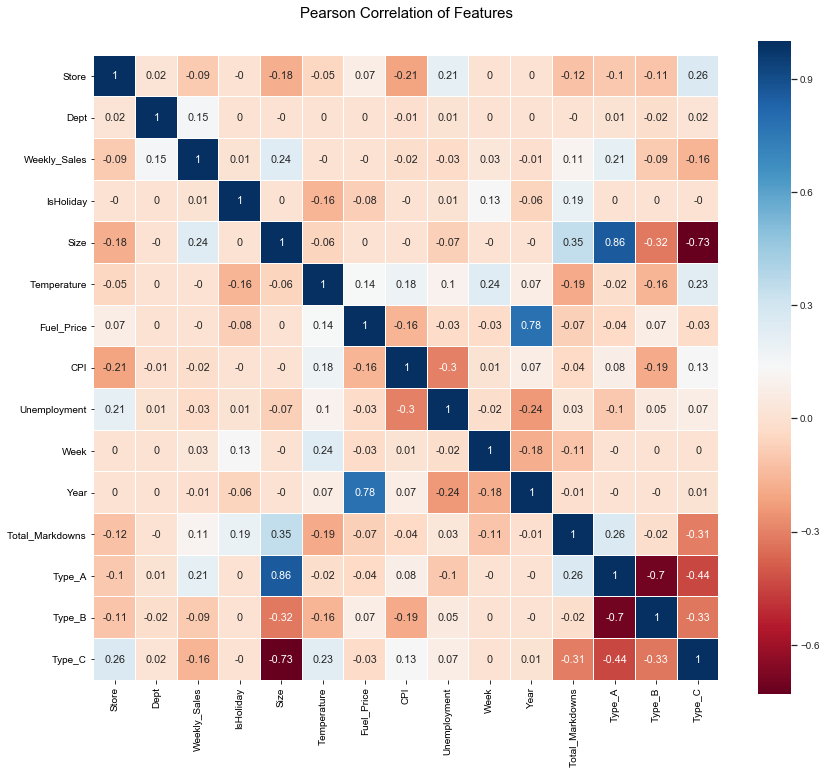

In [27]:
colormap = plt.cm.RdBu
corr = train.astype(float).corr()

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)



In [28]:
corr_cutoff = 0.8
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_cutoff:
            if columns[j]:
                columns[j] = False
                
selected_columns = train.columns[columns]
highcorr_columns = train.columns.difference(selected_columns)

In [29]:
highcorr_columns

Index(['Type_A'], dtype='object')

In [30]:
train.drop(columns=highcorr_columns, axis=1, inplace=True)
test.drop(columns=highcorr_columns, axis=1, inplace=True)

We drop Type_A as it has a correlation of 0.86 with size. Our criteria for elimination was any variable above 0.8.
This was based on the correlation heatmap that we created

In [68]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Week,Year,Total_Markdowns,Type_B,Type_C
0,1,1,24924.50,0,151315,42.31,2.572,211.096358,8.106,5,2010,76351.07,0,0
1,1,1,46039.49,1,151315,38.51,2.548,211.242170,8.106,6,2010,36311.85,0,0
2,1,1,41595.55,0,151315,39.93,2.514,211.289143,8.106,7,2010,32757.37,0,0
3,1,1,19403.54,0,151315,46.63,2.561,211.319643,8.106,8,2010,26272.33,0,0
4,1,1,21827.90,0,151315,46.50,2.625,211.350143,8.106,9,2010,50479.69,0,0


# Feature Importance

In [33]:
X = train[['Dept','IsHoliday','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_Markdowns','Type_B','Type_C']]
y = train['Weekly_Sales']

In [34]:
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0)

model = randomforest.fit(X, y)

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model, threshold=0.05)
sfm.fit(X, y)
for feature_list_index in sfm.get_support(indices=True):
    print(X.columns[feature_list_index])
    
pd.DataFrame(list(zip(X.columns,model.feature_importances_)), columns = ['predictor','Gini coefficient'])

C:\Users\irind\Anaconda3\envs\MMA_Test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Dept
Size


,predictor,Gini coefficient
0,Dept,0.618438
1,IsHoliday,0.009831
2,Size,0.228494
3,Temperature,0.023128
4,Fuel_Price,0.014253
5,CPI,0.037308
6,Unemployment,0.027320
7,Total_Markdowns,0.032004
8,Type_B,0.006588
9,Type_C,0.002636


# Predicting Weekly Sales

## Linear Regression

In [35]:
X = train[['Dept','IsHoliday','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_Markdowns','Type_B','Type_C']]
y = train['Weekly_Sales']

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5)


In [37]:
from sklearn.linear_model import LinearRegression
lm_sales = LinearRegression()
model_lm = lm_sales.fit(X,y)


In [38]:
y_val_pred = lm_sales.predict(X_val)

In [39]:
from sklearn.metrics import mean_squared_error
mse_lm = mean_squared_error(y_val, y_val_pred)

RMSE_lm = (mse_lm)**(1/2)
print(RMSE_lm)

21445.67365885541


## Random Forest Regression

In [40]:
rf = RandomForestRegressor(random_state=5, n_estimators = 100)
model = rf.fit(X_train,y_train)

y_test_pred = rf.predict(X_val)

mse_rf = mean_squared_error(y_val,y_test_pred)
RMSE_rf = (mse_rf)**(1/2)
print(RMSE_rf)

5511.033728839515


## LightGBM

In [41]:
import xgboost as xgb


In [42]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\irind\Anaconda3\envs\MMA_Test\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\irind\Anaconda3\envs\MMA_Test\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [43]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [44]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_val)

[13:00:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
rmse = np.sqrt(mean_squared_error(y_val, preds))
print("RMSE: %f" % (rmse))

RMSE: 10403.909351


## KNN Regressor

In [46]:
from sklearn.neighbors import KNeighborsRegressor


In [47]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X_std = standardizer.fit_transform(X)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.33, random_state = 5)

In [49]:
knn = KNeighborsRegressor(n_neighbors=2)
model_KNN = knn.fit(X_train,y_train)

In [50]:
y_test_pred = knn.predict(X_test)

In [51]:
from sklearn.metrics import mean_squared_error
mse_KNN = mean_squared_error(y_test, y_test_pred)
print(mse_KNN)

443527966.89054954


In [52]:
RMSE_KNN = (mse_KNN)**(1/2)
print(RMSE_KNN)

21060.103677108276


## Stacked Regression

In [53]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [54]:
from mlxtend.regressor import StackingRegressor

In [55]:
stregr = StackingRegressor(regressors=[model_lm, xg_reg,model_KNN], meta_regressor=rf)

In [56]:
stregr.fit(X,y)

C:\Users\irind\Anaconda3\envs\MMA_Test\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\irind\Anaconda3\envs\MMA_Test\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:02:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(meta_regressor=RandomForestRegressor(bootstrap=True,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       oob_score=False,
                       

In [57]:
stregr.predict(X)

array([28691.9195, 44288.9065, 42372.8655, ...,  1081.9412,   955.671 ,
         900.459 ])

In [58]:
print("Mean Squared Error: %.4f"
      % np.mean((stregr.predict(X) - y) ** 2))

Mean Squared Error: 6432607.9489


In [59]:
mse = np.mean((stregr.predict(X) - y) ** 2)
rmse = (mse)**(1/2)

In [60]:
print("RMSE: %.4f" 
      % rmse)

RMSE: 2536.2587


# Causal Inference

In [94]:
import dowhy
from dowhy import CausalModel

In [104]:
model=CausalModel(
        data = train,
        treatment=["IsHoliday"],
        outcome="Weekly_Sales",
        common_causes = ['Store','Dept','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_Markdowns','Type_B','Type_C'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['IsHoliday'] on outcome ['Weekly_Sales']


In [105]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)


estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'Temperature', 'Dept', 'Unemployment', 'Total_Markdowns', 'Type_C', 'Store', 'Type_B', 'CPI', 'Size', 'Fuel_Price']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Weekly_Sales~IsHoliday+Temperature+Dept+Unemployment+Total_Markdowns+Type_C+Store+Type_B+CPI+Size+Fuel_Price


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(Weekly_Sales|Temperature,Dept,Unemployment,Total_Mark
d[IsHoliday]                                                                  

                                               
downs,Type_C,Store,Type_B,CPI,Size,Fuel_Price))
                                               
Estimand assumption 1, Unconfoundedness: If U→{IsHoliday} and U→Weekly_Sales then P(Weekly_Sales|IsHoliday,Temperature,Dept,Unemployment,Total_Markdowns,Type_C,Store,Type_B,CPI,Size,Fuel_Price,U) = P(Weekly_Sales|IsHoliday,Temperature,Dept,Unemployment,Total_Markdowns,Type_C,Store,Type_B,CPI,Size,Fuel_Price)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Weekly_Sales~IsHoliday+Temperature+Dept+Unemployment+Total_Markdowns+Type_C+Store+Typ

In [106]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Weekly_Sales~IsHoliday+Temperature+Dept+Unemployment+Total_Markdowns+Type_C+Store+Type_B+CPI+Size+Fuel_Price+w_random


Refute: Add a Random Common Cause
Estimated effect:(740.0316245247413,)
New effect:(740.1212040839982,)



In [100]:
model2=CausalModel(
        data = train,
        treatment=["Unemployment"],
        outcome="Weekly_Sales",
        common_causes = ['Store','Dept','IsHoliday','Size','Temperature','Fuel_Price','CPI','Total_Markdowns','Type_B','Type_C'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Unemployment'] on outcome ['Weekly_Sales']


In [101]:
identified_estimand = model2.identify_effect(proceed_when_unidentifiable=True)


estimate = model2.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'Temperature', 'Dept', 'IsHoliday', 'Total_Markdowns', 'Type_C', 'Store', 'Type_B', 'CPI', 'Size', 'Fuel_Price']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Weekly_Sales~Unemployment+Temperature+Dept+IsHoliday+Total_Markdowns+Type_C+Store+Type_B+CPI+Size+Fuel_Price


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(Weekly_Sales|Temperature,Dept,IsHoliday,Total_Mark
d[Unemployment]                                                               

                                               
downs,Type_C,Store,Type_B,CPI,Size,Fuel_Price))
                                               
Estimand assumption 1, Unconfoundedness: If U→{Unemployment} and U→Weekly_Sales then P(Weekly_Sales|Unemployment,Temperature,Dept,IsHoliday,Total_Markdowns,Type_C,Store,Type_B,CPI,Size,Fuel_Price,U) = P(Weekly_Sales|Unemployment,Temperature,Dept,IsHoliday,Total_Markdowns,Type_C,Store,Type_B,CPI,Size,Fuel_Price)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Weekly_Sales~Unemployment+Temperature+Dept+IsHoliday+Total_Markdowns+Type_C+Store+

In [103]:
res_random=model2.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Weekly_Sales~Unemployment+Temperature+Dept+IsHoliday+Total_Markdowns+Type_C+Store+Type_B+CPI+Size+Fuel_Price+w_random


Refute: Add a Random Common Cause
Estimated effect:(-233.69428936730765,)
New effect:(-233.6890168870741,)



# Recommendations

1) Targeting specific Departments for promotions will be more useful.
2) Markdowns don't have a very strong effect on sales.
3) Should not worry too much about Macro-economic conditions because Walmart already is at an affordable price point.
4) Focus on larger stores such as Type A and B as they contribute the most in total Sales.
5) Focus on satisfying the interests of employees and suppliers to improve stakeholder management.

# Future Work

1) Adding data on extreme weather conditions (ie. hurricanes, etc.).  Supermarkets usually run out of stocks and are almost never prepared for such events.
2) Including location vs. population.  Zip code information with nationality information can help refine assortment, and should be included in a model.
3) Ecommerce presence to check the significance of sales coming from online retail.